In [ ]:
# default_exp simulation

# Simulation

> Tools for  simulating cellular vertex dynamics. Iterative algorithm implementations, cell monolayer generators (vertices). (anything else to add?!)

- numerical integration method(s)
    - Euler's method
    - any other approximation?
- implement functions for checking:
    - vertex configuration (for high tension cases there might be overlapping, or twisted cells which are considered illigal by the model)
    - update steps that implement required vertex check, and any other checks needed before accepting vertex position update
- implement Voronoi cell generator for different cell configuration cases (random, evenly spaced, concave cell, ...)

In [ ]:
#hide
from nbdev.showdoc import *

In [ ]:
#hide
from vertex_simulation.primitives import *
%load_ext autoreload
%autoreload 2

In [ ]:
#export
import torch, numpy as np, matplotlib.pylab as plt
from scipy.spatial import Voronoi,voronoi_plot_2d

## Euler's method

In [ ]:
# define function for numerical integration

## Cell monolayer graph generators

In [ ]:
#export
def unit_hexagons(Nx,Ny):
    '''Produces hexagons with unit length edges, arranged in a hexagonal lattice.'''
    # for regular hexagons with unit length edges
    dXY = [np.sqrt(3), 1.5] # original grid spacing
    x_offset = np.sqrt(3)/2 # moves alter-g rows to the right (+ x-axis)
    X,Y = np.meshgrid(np.linspace(0,(Nx-1)*dXY[0],Nx),np.linspace(0,(Ny-1)*dXY[1],Ny))
    X[1::2,:]+=x_offset
    Xseed = np.concatenate((X.ravel()[:,np.newaxis],Y.ravel()[:,np.newaxis]),axis=1)
    vrn = Voronoi(Xseed)
#     #region with all vertices >0
#     regions = [r for r in vrn.regions if (not np.any(vrn.vertices[r,0]<0)) and len(r)]
    return vrn
    


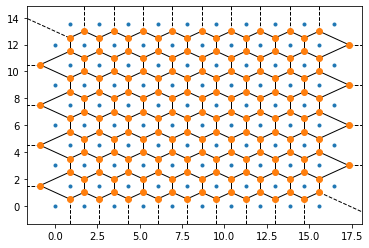

In [ ]:
vrn =unit_hexagons(10,10)

voronoi_plot_2d(vrn)
# plt.vlines(0,0,18,'y',lw=4)
# plt.vlines(np.sqrt(3)*(12-1),0,18,'y',lw=4)
plt.show()

# edge_list,cells = VoronoiRegions2Edges(vrn.regions)
# len(cells)

In [ ]:
list(range(1,10,2))

[1, 3, 5, 7, 9]

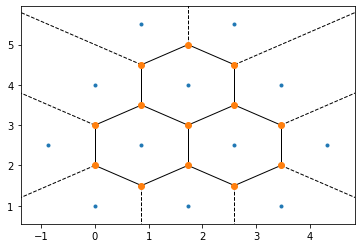

In [ ]:
#hide
v_seeds = np.array([[np.sqrt(3)/2,5.5], [1.5*np.sqrt(3),5.5], [0.,4.],
                  [np.sqrt(3),4.],[2*np.sqrt(3),4.],[-np.sqrt(3)/2,2.5],
                  [np.sqrt(3)/2,2.5],[1.5*np.sqrt(3),2.5],[2.5*np.sqrt(3),2.5],
                  [0.,1.],[2*np.sqrt(3),1.], [np.sqrt(3),1.]])

vrn = Voronoi(v_seeds)
voronoi_plot_2d(vrn)
ax_lims = plt.axis()
plt.show()

edge_list,cells = VoronoiRegions2Edges(vrn.regions) # convert regions to edges and cells
# print(cells)

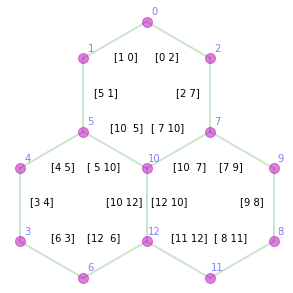

In [ ]:
#hide

edge_list,cells = VoronoiRegions2Edges(vrn.regions)

verts = Vertex(vrn.vertices)
edges = torch.tensor(edge_list)

plt.figure(figsize=[5,5])
plot_graph(verts.x,edges)

# vertex indices
for k,v in enumerate(vrn.vertices):
    plt.text(v[0]+.1,v[1]+.1,f"{k}",c='b',ha='center',alpha=.5)

# cell edges
for c in cells:
    cell_edges = edges[np.abs(cells[c])-1,:] # edge indices (without direction)
    if np.any(np.sign(cells[c])<0):
        # reverse vertex order for negative edges
        tmp = cell_edges[np.sign(cells[c])<0,:].clone()
        cell_edges[np.sign(cells[c])<0,0]=tmp[:,1]
        cell_edges[np.sign(cells[c])<0,1]=tmp[:,0]
    cell_xy = torch.mean(verts.x[cell_edges[:,0],:],0)
    for e in cell_edges:
        e_xy = torch.mean(verts.x[e,:],0)*.65+cell_xy*.35
        plt.text(e_xy[0],e_xy[1],f"{e.numpy()}",ha='center')
plt.show()

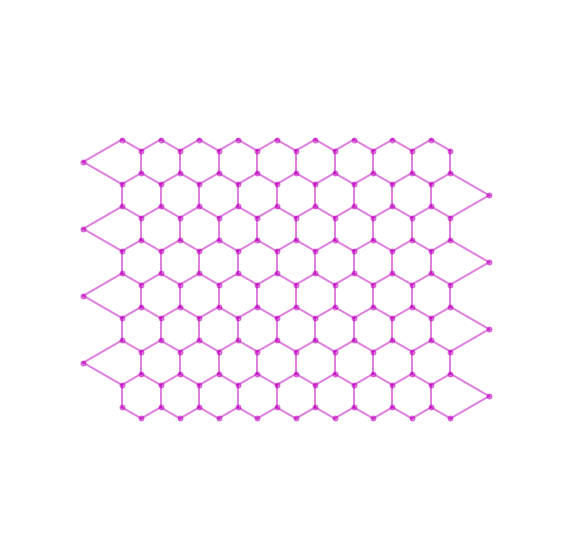

Integration (Euler's method):


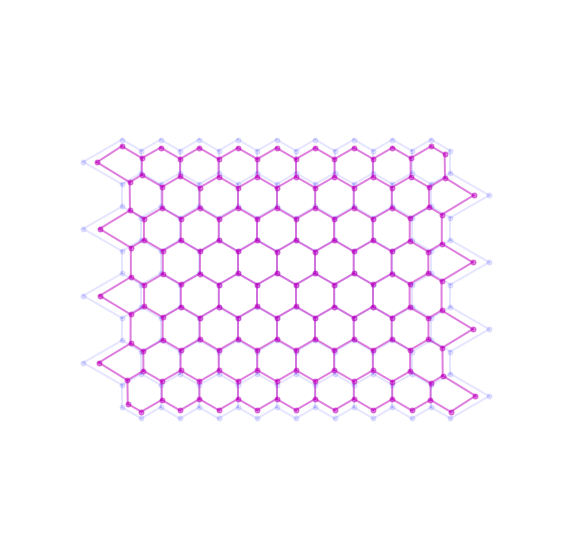

t=0.250: E=4e+01; aver |dx/dt|= 0.6


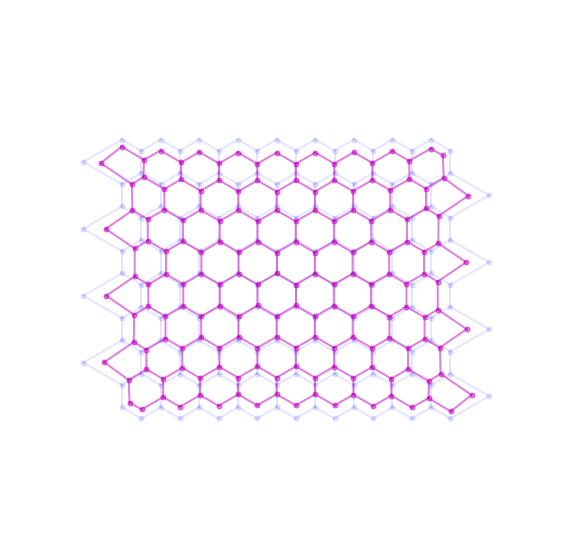

t=0.500: E=3e+01; aver |dx/dt|= 0.4


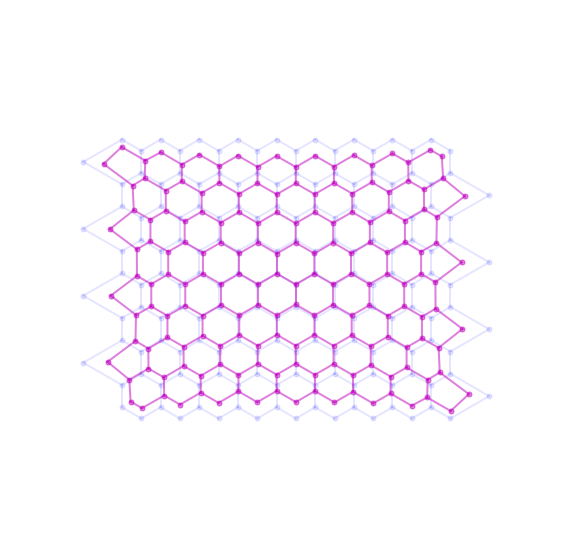

t=0.750: E=2e+01; aver |dx/dt|= 0.3


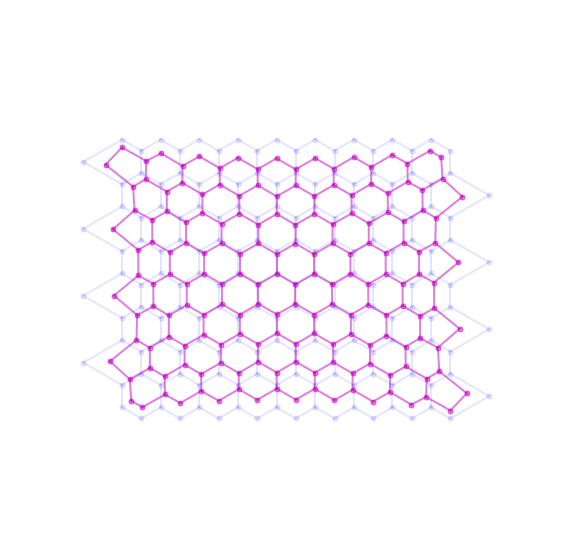

t=1.000: E=2e+01; aver |dx/dt|= 0.2


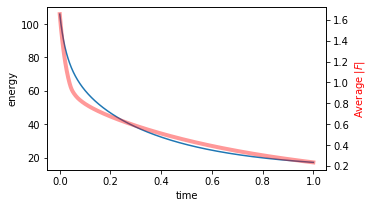

Perimeters:tensor([5.3595, 5.3796, 5.3246, 5.3630, 5.4373, 5.3501, 5.3996, 5.3939, 5.4682,
        5.3718, 5.3521, 5.3886, 5.3796, 5.3037, 5.3726, 5.3602, 5.3592, 5.3321,
        5.3246, 5.3501, 5.3630, 5.3996, 5.3939, 5.3521, 5.3718, 5.3886, 5.4520,
        5.3592, 5.5289, 5.3602, 5.3037, 5.3321, 5.3595, 5.4143, 5.3726, 5.4955,
        5.4939, 5.5486, 5.4609, 5.4171, 5.4354, 5.3791, 5.3701, 5.4637, 5.4688,
        5.3755, 5.5644, 5.5154, 5.5362, 5.5722, 5.5259, 5.4609, 5.4171, 5.4143,
        5.4354, 5.4955, 5.3701, 5.5486, 5.5722, 5.4939, 5.5154, 5.5644, 5.5259,
        5.4682, 5.4373, 5.4688, 5.5362, 5.4637, 5.3791, 5.3755, 5.4520, 5.5289],
       dtype=torch.float64)
Areas:tensor([1.8936, 1.9199, 2.0146, 1.8687, 2.1255, 2.0449, 2.0955, 2.0895, 2.1555,
        1.9136, 2.0344, 2.0725, 1.9199, 1.9928, 2.0600, 2.0616, 2.0542, 2.0316,
        2.0146, 2.0449, 1.8687, 2.0955, 2.0895, 2.0344, 1.9136, 2.0725, 2.1368,
        2.0542, 2.2024, 2.0616, 1.9928, 2.0316, 1.8936, 2.1083, 2.0600, 2.

In [ ]:
#hide
edge_list,cells = VoronoiRegions2Edges(vrn.regions)
# using Voronoi tesselation from above:
verts = Vertex(vrn.vertices)
edges = torch.tensor(edge_list)

cell_graph = Monolayer(vertices=Vertex(vrn.vertices.copy()), edges=edges, cells=cells)
cell_graph.vertices.requires_grad_(True)

# initial state
figsize=[10,10]
plt.figure(figsize=figsize)
plot_graph(vrn.vertices,cell_graph.edges,plot_arg=['m-','m.'],alphas=[.5])
axs_lims = np.array(plt.axis())
hw = 1.25*(axs_lims[1::2]-axs_lims[0::2])/2
xy_0 = [axs_lims[:2].mean(), axs_lims[2:].mean()]
axs_lims = [xy_0[0]-hw[0],xy_0[0]+hw[0],xy_0[1]-hw[1],xy_0[1]+hw[1]]
plt.axis(axs_lims)
plt.show()

# Define energy function
k=1.0
energy = lambda p,a: torch.sum((p-5)**2)+torch.sum((a-2.3)**2) #
# Numerical integration
Dt = 2**-12 # time step size
t = [0]
Energies = []
Forces = []
print('Integration (Euler\'s method):')
t_total = 2**12
for n in range(t_total):
    cell_graph.set_zero_grad_() # reset grad accumulator
    E = energy(cell_graph.perimeter(),cell_graph.area())  # total potential energy of the system
    Energies.append(E.item()) # E(t-1)
    E.backward() # compute gradients
    dxdt = -cell_graph.get_vertex_grad() # dx/dt=-dE/dx
    # Update vertex position
    with torch.no_grad():
        cell_graph.vertices.x += dxdt*Dt
        Forces.append(torch.norm(dxdt,dim=1).mean().item())
    t.append(t[-1]+Dt)
    if round((n+1)%(t_total/4))==0:
        plt.figure(figsize=figsize)
        plot_graph(vrn.vertices,cell_graph.edges,plot_arg=['b-','b.'],alphas=[.1])
        plot_graph(cell_graph.vertices.x.detach(),cell_graph.edges,plot_arg=['m-','m.'],alphas=[.5])
        plt.axis(axs_lims)
        plt.show()
        mean_grad = torch.norm(dxdt,dim=1).mean().item()
        print(f't={t[-1]:2.3f}: E={E.item():1.1g}; aver |dx/dt|= {mean_grad:1.1g}')
Energies.append( energy(cell_graph.perimeter(),cell_graph.area()).item() )
plt.figure(figsize=[5,3])
plt.plot(t,Energies);plt.xlabel('time');plt.ylabel('energy');
# add forces (except last frame)
ax2=plt.gca().twinx()
ax2.set_ylabel('Average $|F|$',color='red')
ax2.plot(t[:-1],Forces,'r-',alpha=.4,lw=4)
plt.show()
# Print final Perimeters and Areas
print(f"Perimeters:{cell_graph.perimeter().detach().squeeze()}\nAreas:{cell_graph.area().detach()}")

In [ ]:
#hide
# run this as a last cell in your notebook to export this module
from nbdev.export import *
notebook2script()

Converted 00_primitives.ipynb.
Converted 01_simulation.ipynb.
Converted index.ipynb.
Converted vertex_dynamics_models.ipynb.
